# Setup the PEST(++) interface around the enhanced Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing MODFLOW-NWT model using the python/flopy/pyemu stack.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu
import prep_deps
import redis

flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
b_d = os.path.join("..","base_model_files")
nam_file = "freyberg.nam"

This seemingly simple function call will spatially rediscretize the original freyberg model by cutting each row and column by 3's

In [3]:
#redis_fac = 3
#mr = redis.redis_freyberg(fac=redis_fac,b_d=b_d)
#b_d = mr.model_ws

### load the model and run once to make sure everything is good-to-go

In [4]:
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)


In [5]:
m.exe_name = "mfnwt"
m.change_model_ws("temp",reset_external=True)
m.write_input()
prep_deps.prep_template(t_d="temp")
pyemu.os_utils.run("{0} {1}".format("mfnwt",m.name+".nam"),cwd=m.model_ws)


changing model workspace...
   temp


[Text(0, 0, 'historic'), Text(0, 0, 'scenario')]

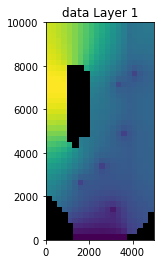

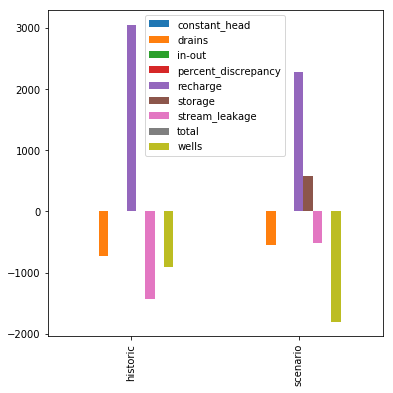

In [6]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot(mflay=0)
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
ax.set_xticklabels(["historic","scenario"])

We can see the effect of the "scenario" in the second stress period with less recharge and more abstraction. 

Plot depth to water

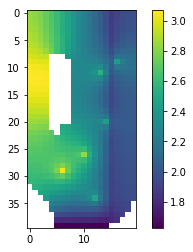

In [7]:
dtw = m.dis.top.array - hds.get_data()[0,:,:]
dtw = np.ma.masked_where(m.bas6.ibound[0].array==0,dtw)
c = plt.imshow(dtw)
plt.colorbar(c)
plt.show()

We are going to do is implement the scenario with parameters so we can more easy account for the stochastic nature of the forcing conditions during the scenario stress period and also make implemention of future scenarios work in this stochastic framework:

[Text(0, 0, 'historic'), Text(0, 0, 'scenario')]

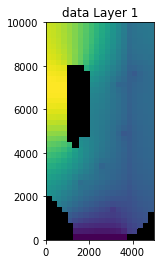

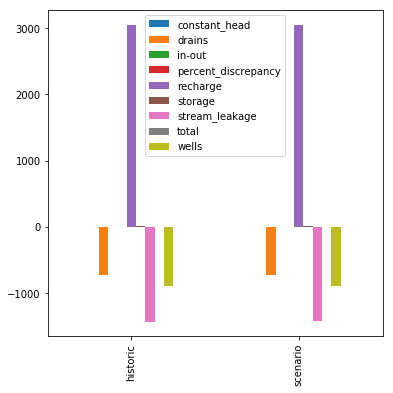

In [8]:
# reset scenario period recharge
m.rch.rech[1] = m.rch.rech[0]
# reset scenario period abstraction
m.wel.stress_period_data[1] = m.wel.stress_period_data[0]
m.write_input()
pyemu.os_utils.run("{0} {1}".format("mfnwt",m.name+".nam"),cwd=m.model_ws)
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
axes = hds.plot(mflay=0)

lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
ax.set_xticklabels(["historic","scenario"])

Now we see that the scenario and historic periods have the same water balance

### setup data structures related to what we want to parameterize and what we want to observe

In [9]:
props = []
paks = ["upw.hk","upw.vka","upw.ss","upw.sy","bas6.strt","extra.prsity"]
for k in range(m.nlay):
    props.extend([[p,k] for p in paks])
props.append(["rch.rech",0])
props.append(["rch.rech",1])


In [10]:
spatial_list_props = [["wel.flux",2],["drn.cond",0]]
temporal_list_props = [["wel.flux",0],["wel.flux",1]]

In [11]:
hds_kperk = [[0,k] for k in range(m.nlay)]
hds_kperk.extend([[1,k] for k in range(m.nlay)])

Here we setup monitoring of the SFR ASCII outputs.  we will accumulate the first 20 reaches and last 20 reaches together to form forecasts of sw-gw exchange in the headwaters (`hw`) and tailwaters (`tw`).  Then we will also add each reach individually for monitoring as well

In [12]:
sfr_obs_dict = {"hw":np.arange(1,int(m.nrow/2))}
sfr_obs_dict["tw"] = np.arange(int(m.nrow/2),m.nrow)
for i in range(m.nrow):
    sfr_obs_dict[i] = i+1

### here we go...

This class has grown into a monster...it does (among other things):
- sets up combinations of multiplier parameters for array inputs, including uniform, zones, pilot points, grids, and KL expansion types
- sets up combinations of multiplier parmaeters for list inputs
- handles several of the shitty modflow exceptions to the array and list style inputs
- sets up large numbers of observations based on arrays or time series
- writes .tpl, .ins, .pst, etc
- writes a python forward run script (WAT?!)
- writes a prior parameter covaraince matrix using geostatistical correlations
- draws from the prior parameter covariance matrix to generate a prior parameter ensemble

This will be slow because the pure python kriging...but, hey, its free!


In [13]:
pst_helper = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws="template",org_model_ws="temp",
                                            const_props=props,spatial_list_props=spatial_list_props,
                                             temporal_list_props=temporal_list_props,remove_existing=True,
                                            grid_props=props,pp_props=props,sfr_pars=True,hds_kperk=hds_kperk,
                                             sfr_obs=sfr_obs_dict,build_prior=False,model_exe_name="mfnwt",
                                            pp_space=4)
prep_deps.prep_template(t_d=pst_helper.new_model_ws)

2019-05-02 21:57:37.058610 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:temp/freyberg.list, filetype:LIST), (11, filename:temp/freyberg.dis, filetype:DIS), (13, filename:temp/freyberg.bas, filetype:BAS6), (31, filename:temp/freyberg.upw, filetype:UPW), (19, filename:temp/freyberg.rch, filetype:RCH), (32, filename:temp/freyberg.nwt, filetype:NWT), (14, filename:temp/freyberg.oc, filetype:OC), (30, filename:temp/freyberg.lmt6, filetype:LMT6), (20, filename:temp/freyberg.wel, filetype:WEL), (17, filename:temp/freyberg.sfr, filetype:SFR), (21, filename:temp/freyberg.drn, filetype:DRN), (50, filename:temp/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:temp/freyberg.hds, filetype:DATA(BINARY)), (60, filename:temp/freyberg.sfr.out, filetype:DATA)])
-------------------

The `pst_helper` instance contains the `pyemu.Pst` instance:

In [14]:
pst = pst_helper.pst
pst.npar,pst.nobs

(14819, 4434)

Oh snap!

### Add modpath input files, instruction files and calls

In [15]:
mp_files = [f for f in os.listdir(b_d) if "mp" in f or "location" in f]
[shutil.copy2(os.path.join(b_d,f),os.path.join(pst_helper.new_model_ws,f)) for f in mp_files]

['template/mp_ibound_1.ref',
 'template/mp_ibound_2.ref',
 'template/mp_ibound_3.ref',
 'template/freyberg.locations',
 'template/freyberg.mpsim',
 'template/freyberg.mpbas',
 'template/freyberg.mpnam']

In [16]:
pst_helper.frun_post_lines.append("os.system('mp6 freyberg.mpsim >mp6.stdout')")
pst_helper.tmp_files.append("freyberg.mpenpt")
pst_helper.write_forward_run()

In [17]:
out_file = "freyberg.mpenpt"
ins_file = out_file + ".ins"
with open(os.path.join(pst_helper.new_model_ws,ins_file),'w') as f:
    f.write("pif ~\n")
    f.write("l7 w w w !part_status! w w !part_time!\n")
df = pst_helper.pst.add_observations(os.path.join(pst_helper.new_model_ws,ins_file),os.path.join(pst_helper.new_model_ws,out_file),pst_path=".")

error using inschek for instruction file ./freyberg.mpenpt.ins:File b'template/./freyberg.mpenpt.obf' does not exist
observations in this instruction file will havegeneric values.


In [18]:
for k in range(m.nlay):
    np.savetxt(os.path.join(pst_helper.new_model_ws,"arr_org","prsity_layer_{0}.ref".format(k+1)),np.zeros((m.nrow,m.ncol))+0.001,fmt="%15.6E")

### Final bits and bobs
We need to set some realistic parameter bounds and account for expected (but stochastic) scenario conditions:

In [19]:
par = pst.parameter_data
# properties
tag_dict = {"hk":[0.1,10.0],"vka":[0.1,10],"strt":[0.95,1.05],"prsity":[0.1,1.0]}
for t,[l,u] in tag_dict.items():
    t_pars = par.loc[par.parnme.apply(lambda x: t in x ),"parnme"]
    par.loc[t_pars,"parubnd"] = u
    par.loc[t_pars,"parlbnd"] = l

# recharge - just change the uniform recharge mult
scen_rch = ["cn_rech5"]
hist_rch = ["cn_rech4"]
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parubnd"] = 0.8
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parlbnd"] = 0.1
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parval1"] = 0.4
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parubnd"] = 1.2
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parlbnd"] = 0.8
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parval1"] = 1.0

# well abstraction
par.loc["welflux_001","parval1"] = 1.5
par.loc["welflux_001","parlbnd"] = 1.0
par.loc["welflux_001","parubnd"] = 2.0
par.loc["welflux_000","parval1"] = 1.0
par.loc["welflux_000","parlbnd"] = 0.5
par.loc["welflux_000","parubnd"] = 1.5



In [20]:
# table can also be written to a .tex file
pst.write_par_summary_table(filename="none").sort_index()

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0,-1,0.25
cn_prsity7,cn_prsity7,log,1,0,0,-1,0.25
cn_prsity8,cn_prsity8,log,1,0,0,-1,0.25
cn_rech4,cn_rech4,log,1,0,0.0791812,-0.09691,0.0440228
cn_rech5,cn_rech5,log,1,-0.39794,-0.09691,-1,0.225772
cn_ss6,cn_ss6,log,1,0,1,-1,0.5
cn_ss7,cn_ss7,log,1,0,1,-1,0.5


In [21]:
pst.write_obs_summary_table(filename="none")

,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
flaqx,flaqx,-977.239 to 32.171,84,0,1,1,0.102329 to 833.333
flout,flout,10069 to 226396,84,0,1,1,0.000441704 to 0.00993147
flx_constan,flx_constan,0,2,0,1,1,NA
flx_drains,flx_drains,-723.325 to -723.028,2,0,1,1,0.13825 to 0.138307
flx_in-out,flx_in-out,0.012695 to 0.046143,2,0,1,1,2167.18 to 7877.12
flx_percent,flx_percent,0,2,0,1,1,NA
flx_recharg,flx_recharg,3045.6,2,0,1,1,0.0328343
flx_storage,flx_storage,5.7734 to 8.01049,2,0,1,1,12.4836 to 17.3208
flx_stream_,flx_stream_,-1430.27 to -1428.3,2,0,1,1,0.0699167 to 0.0700133
flx_total,flx_total,0.0126953 to 0.0461426,2,0,1,1,2167.2 to 7876.92


Lets run the process once (`noptmax=0`) to make sure its all plumbed up

In [22]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=pst_helper.new_model_ws)


Now we need to generate the prior parameter covariance matrix and stochastic realizations.  We will use the geostatistical covariance information in the `pst_helper` instance for this:

2019-05-02 21:58:02.162939 starting: building prior covariance matrix
2019-05-02 21:58:02.270694 WARNING: geospatial prior not implemented for SFR pars


/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2019-05-02 21:58:08.907720 saving prior covariance matrix to file template/prior_cov.jcb
2019-05-02 21:58:13.235835 finished: building prior covariance matrix took: 0:00:11.072896


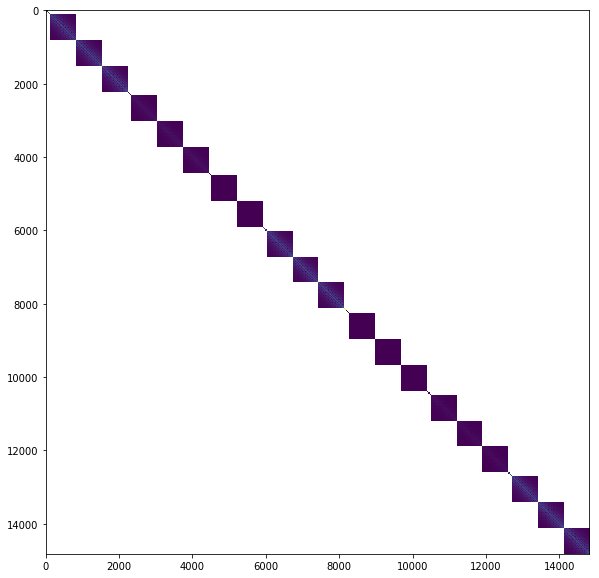

In [23]:
if pst_helper.pst.npar < 15000:
    cov = pst_helper.build_prior(fmt="coo",filename=os.path.join(pst_helper.new_model_ws,"prior_cov.jcb"))
    cov = np.ma.masked_where(cov.x==0,cov.x)
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.imshow(cov)

In [24]:
pe = pst_helper.draw(200)

2019-05-02 21:58:30.155612 starting: drawing realizations
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['pp_hk0']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_vka0']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_ss0']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_sy0']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['pp_strt0']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on parg

/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['welflux_k02']
build cov matrix
done
getting diag var cov 6
scaling full cov by diag var cov
making full cov draws with home-grown goodness
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

working on pargroups ['gr_hk3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['gr_vka3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['gr_ss3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['gr_sy3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making ful

You can see that parameters are treated in parameter group (`pargp`) blocks for this ensemble generation.  Let's plot one parameter:

<Figure size 576x756 with 0 Axes>

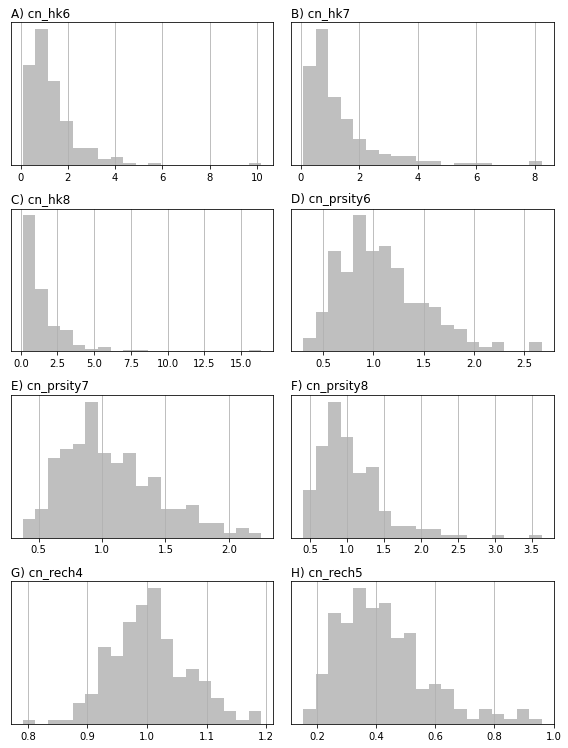

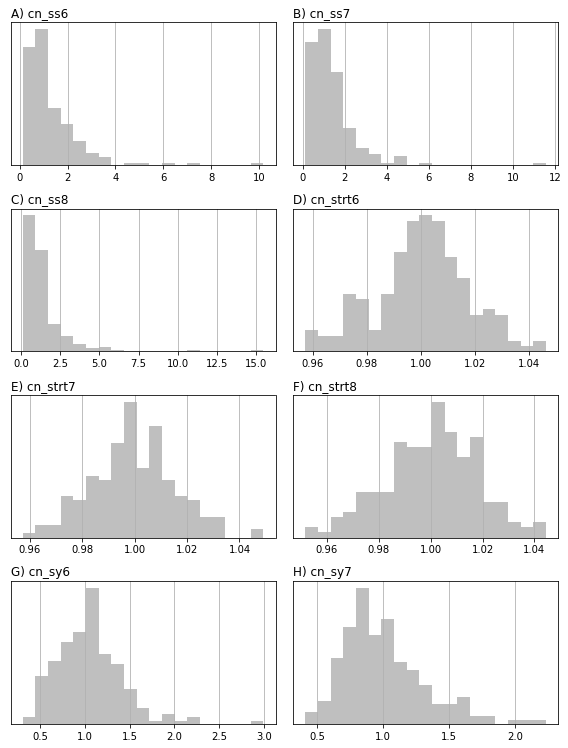

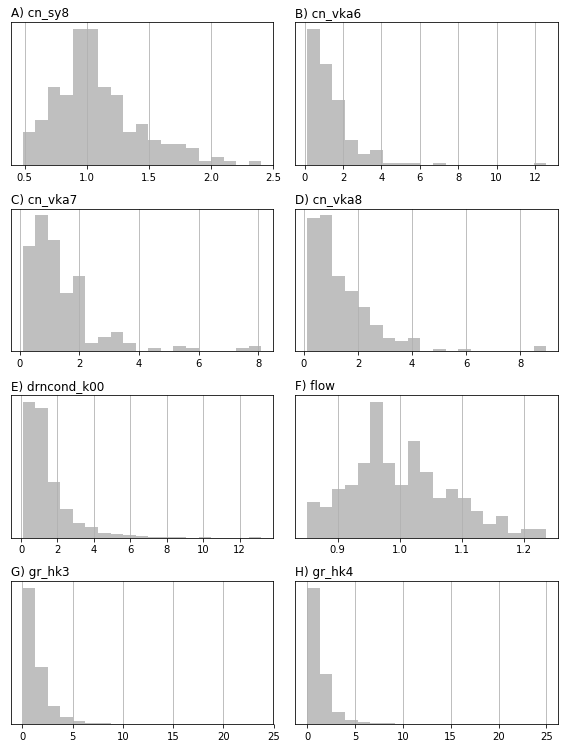

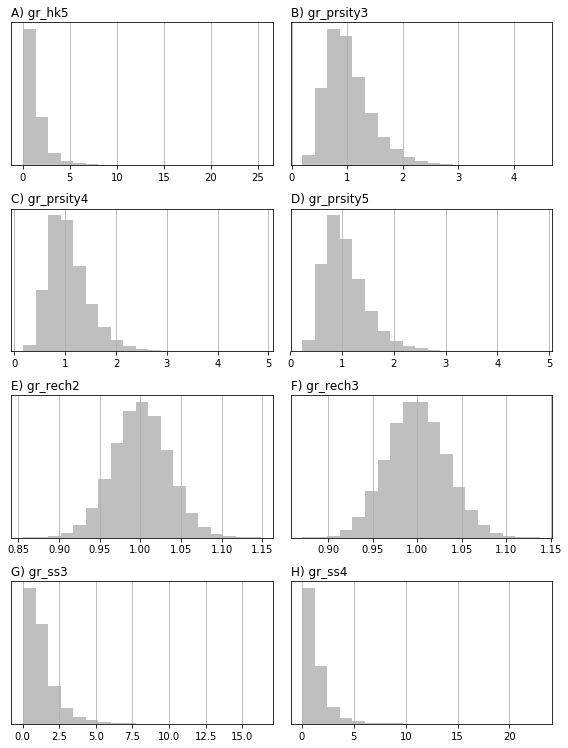

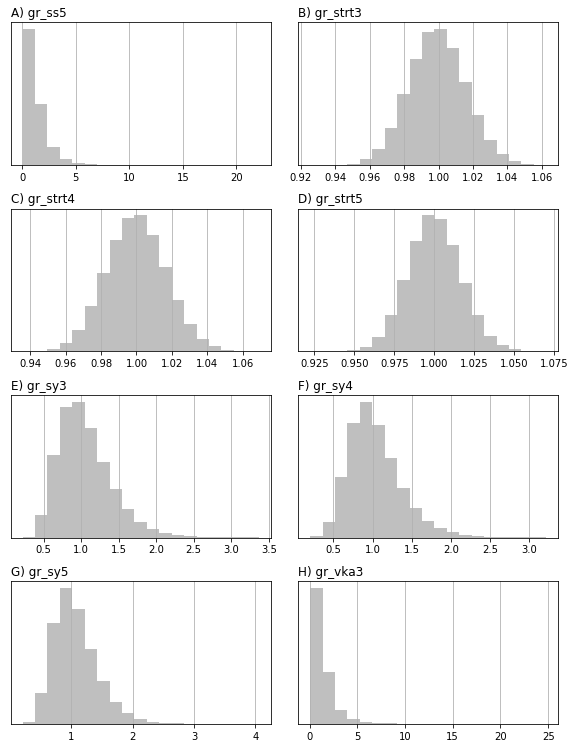

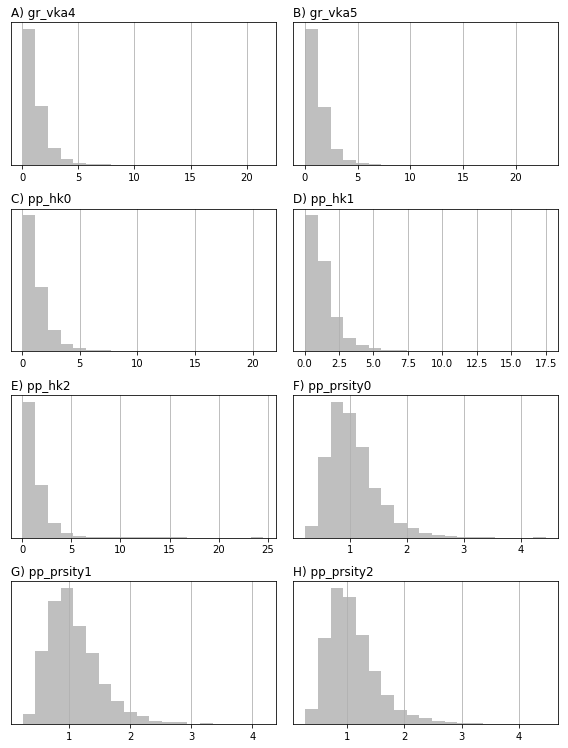

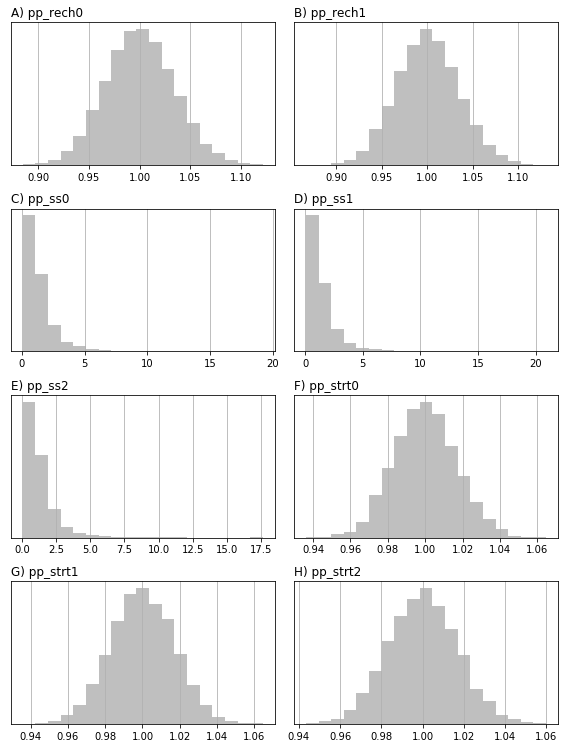

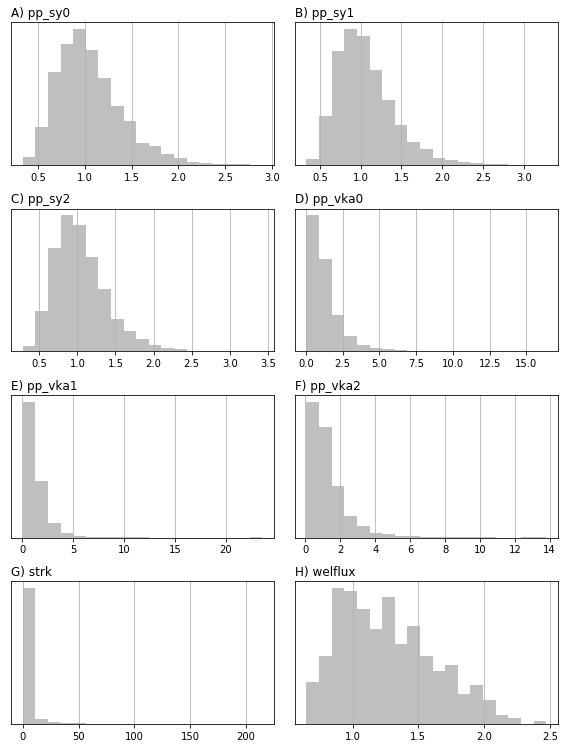

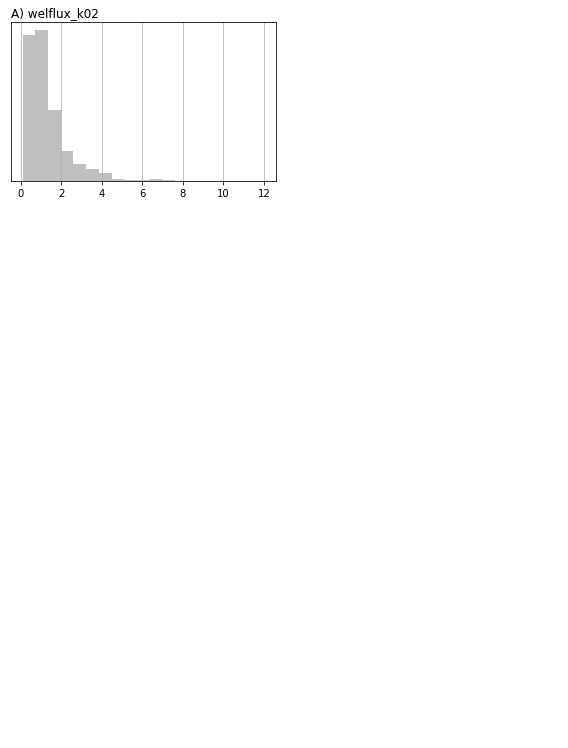

In [25]:
par = pst_helper.pst.parameter_data
pyemu.plot_utils.ensemble_helper(pe,plot_cols=par.groupby("pargp").groups,bins=20)

Now we need to enforce parameter bounds and save this ensemble for later

In [26]:
pe.enforce()
pe.to_binary(os.path.join(pst_helper.new_model_ws,"prior.jcb"))

### set weights for "observations" and identify forecasts

The next major task is to set the weights on the observations.  So far, in the `pst_helper` process, we simply identified what outputs from the model we want to observe.  We now use a pre-cooked csv file to set nonzero weights only for GW level observation locations used in the original Freyberg model.  We will also use the SFR flow out of the last reach (`fo` in the last row in `19791230`)

In [27]:
obs_locs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
if pst_helper.m.nrow != 40:
    obs_locs.loc[:,"row"] = (obs_locs.row * redis_fac) + int(redis_fac / 2.0)
    obs_locs.loc[:,"col"] = (obs_locs.col * redis_fac) + int(redis_fac / 2.0)
#build obs names that correspond to the obsnme values in the control file
obs_locs.loc[:,"obsnme"] = obs_locs.apply(lambda x: "hds_00_{0:03d}_{1:03d}_000".format(x.row-1,x.col-1),axis=1)
obs_locs

,row,col,obsnme
0,3,16,hds_00_002_015_000
1,3,10,hds_00_002_009_000
2,4,9,hds_00_003_008_000
3,10,2,hds_00_009_001_000
4,14,11,hds_00_013_010_000
5,16,17,hds_00_015_016_000
6,22,11,hds_00_021_010_000
7,23,16,hds_00_022_015_000
8,25,5,hds_00_024_004_000
9,27,7,hds_00_026_006_000


Set all weights to zero first, then turn on the weights at only a few locations.  These nonzero obs will be given meaningful weights in the prior monte carlo excersize|

In [28]:
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
obs.loc[obs_locs.obsnme,"weight"] = 1.0
obs.loc[obs_locs.obsnme,"obgnme"] = "calhead"
fo_obs = "fo_{0}_19791230".format(pst_helper.m.nrow-1)
obs.loc[fo_obs,"weight"] = 1.0
obs.loc[fo_obs,"obgnme"] = "calflux"
pst.nnz_obs_names

['fo_39_19791230',
 'hds_00_002_009_000',
 'hds_00_002_015_000',
 'hds_00_003_008_000',
 'hds_00_009_001_000',
 'hds_00_013_010_000',
 'hds_00_015_016_000',
 'hds_00_021_010_000',
 'hds_00_022_015_000',
 'hds_00_024_004_000',
 'hds_00_026_006_000',
 'hds_00_029_015_000',
 'hds_00_033_007_000',
 'hds_00_034_010_000']

Now we will define which model outputs are going to be treated as "forecasts" and save the control file

In [29]:
swgw_forecasts = obs.loc[obs.obsnme.apply(lambda x: "fa" in x and ("hw" in x or "tw" in x)),"obsnme"].tolist()
print(swgw_forecasts)
hds_fore_name = "hds_00_{0:03d}_{1:03d}".format(int(pst_helper.m.nrow/3),int(pst_helper.m.ncol/10))
hds_forecasts = obs.loc[obs.obsnme.apply(lambda x: hds_fore_name in x),"obsnme"].tolist()
forecasts = swgw_forecasts
forecasts.extend(hds_forecasts)
forecasts.append("part_time")
forecasts.append("part_status")
pst_helper.pst.pestpp_options["forecasts"] = forecasts
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))

['fa_hw_19791230', 'fa_hw_19801229', 'fa_tw_19791230', 'fa_tw_19801229']


Run one last time.  `phi` should be near zero since we haven't change the `parval1` values for historic stress period and only the 13 gw level obs have nonzero weights

In [30]:
pyemu.os_utils.run("pestpp-ies.exe freyberg.pst",cwd=pst_helper.new_model_ws)
pst = pyemu.Pst(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pst.phi

9.456182577320024e-19

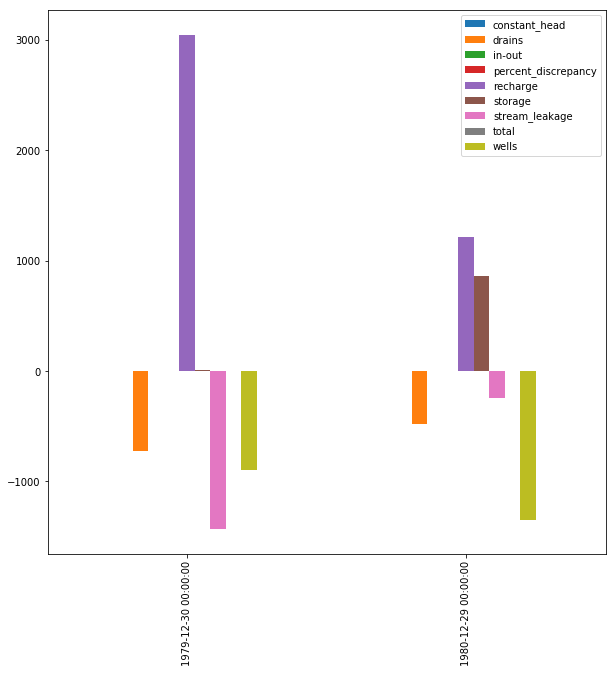

In [31]:
lst = flopy.utils.MfListBudget(os.path.join("template","freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

We see the effect of our parameterized scenario - a large drop in recharge and more abstraction.